# Demo for Anomaly Detection on the PenDigits data set using Randomized Signature as Features

In [2]:
import numpy as np
import pandas as pd
import util
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from RandomSignature import *
import sklearn.metrics
import sklearn.preprocessing
import time
from mpl_toolkits import mplot3d

### Loading the data set:

In [3]:
data = {'train': util.load_pendigits_dataset('../Data/PenDigits_Data/pendigits-orig.tra'),
        'test': util.load_pendigits_dataset('../Data/PenDigits_Data/pendigits-orig.tes')}

dataframes = []
for subset, data in data.items():
    df = pd.DataFrame(data).T
    df.columns = ['Stream', 'Digit']
    df['Subset'] = subset
    dataframes.append(df)
df = pd.concat(dataframes)

### Inspecting the data set

                                              Stream Digit Subset
0  [[267.0, 333.0], [267.0, 336.0], [267.0, 339.0...     8  train
1  [[249.0, 234.0], [249.0, 235.0], [251.0, 238.0...     2  train
2  [[196.0, 228.0], [193.0, 222.0], [191.0, 218.0...     1  train
3  [[231.0, 309.0], [232.0, 314.0], [232.0, 318.0...     4  train
4  [[200.0, 273.0], [200.0, 273.0], [199.0, 271.0...     1  train


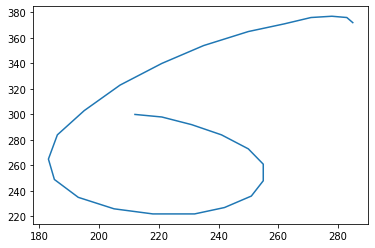

In [4]:
print(df.head())
# df.shape: (10992, 3)
# df.columns: ['Stream', 'Digit', 'Subset']

digit_toplot = 6
df_digit = df[df['Digit'] == digit_toplot]

sample_path = df_digit['Stream'].sample(n=1).to_numpy()[0]

plt.plot(sample_path[:,0],sample_path[:,1])

### Train and evaluate different models 

In [8]:
# fix seed for reproducibility:
np.random.seed(0)

# extract the paths in numpy
paths = df['Stream'].to_numpy()

# normalize each path indiviually
normalized_paths = [sklearn.preprocessing.MinMaxScaler().fit_transform(path) for path in paths]
paths = normalized_paths

# define hyperparameters for the randomized Signature
def identity(x):
    return x
def sigmoid(x):
    return 1/(1+np.exp(-x))

hyperparams_dict = {
'varA':0.005,
'mean':0,
'res_size':10,
'activation': identity
}

# compute the randomized Signature
Sigs = get_signature(paths,hparams = hyperparams_dict)


# define different possible anomaly detector
clf_IF = [IsolationForest(max_samples = 100),'Isolation Forest']
clf_OCSVM = [OneClassSVM(kernel = 'rbf', nu = 0.1), 'One Class SVM']

#### change here to repeat the analysis with different classifier
clf = clf_OCSVM
####
print('Method used: ', clf[1], '\n')
_,_,_,_,_ = util.evaluate_over_digits(Sigs,df,clf[0],verbose = 'True')


Method used:  One Class SVM 

Accuracy for digit  0 :  0.983704974271012
ROC AUC for digit  0 :  0.9971019459492709 

Accuracy for digit  1 :  0.7715837621497998
ROC AUC for digit  1 :  0.8282195628239023 

Accuracy for digit  2 :  0.8965122927387078
ROC AUC for digit  2 :  0.9477697637397701 

Accuracy for digit  3 :  0.9311034877072613
ROC AUC for digit  3 :  0.9665992741182494 

Accuracy for digit  4 :  0.9668381932532876
ROC AUC for digit  4 :  0.9719489189814653 

Accuracy for digit  5 :  0.7761578044596913
ROC AUC for digit  5 :  0.8693871772972003 

Accuracy for digit  6 :  0.8619210977701544
ROC AUC for digit  6 :  0.9474262823408933 

Accuracy for digit  7 :  0.8416237850200115
ROC AUC for digit  7 :  0.9223511013555685 

Accuracy for digit  8 :  0.9719839908519153
ROC AUC for digit  8 :  0.9926188217222373 

Accuracy for digit  9 :  0.7232704402515723
ROC AUC for digit  9 :  0.867364687810608 

Mean accuracy:  0.8724699828473413
Mean ROC AUC:  0.9310787536139166


### Test the effect of increasing reservoir dimension

In [10]:
# fix seed for reproducibility:
np.random.seed(0)

# chosen to match the dimension of the (true) Signature used in Anomaly detection on streamed data, Cochrane et al.
res_sizes = [3,7,15,31,63]

t0 = time.time()

print('Method used: ', clf[1], '\n')
for dim in res_sizes:
    hyperparams_dict['res_size'] = dim
    Sigs = get_signature(paths,hparams = hyperparams_dict)
    mean_accuracy,mean_ROC_AUC,digits_accuracy,digits_ROC_AUC,_ = util.evaluate_over_digits(Sigs,df,clf[0])
    print('Reservoir Size: ', dim)
    print('Mean Accuracy: ', mean_accuracy)
    print('Mean ROC AUC: ', mean_ROC_AUC)
    print('\n')

print('Time needed: ',time.time()-t0)



Method used:  One Class SVM 




Reservoir Size:  3
Mean Accuracy:  0.8354202401372213
Mean ROC AUC:  0.911685031782038





Reservoir Size:  7
Mean Accuracy:  0.8322184105202973
Mean ROC AUC:  0.9067033802173463





Reservoir Size:  15
Mean Accuracy:  0.8759862778730705
Mean ROC AUC:  0.9318441107268352





Reservoir Size:  31
Mean Accuracy:  0.8928244711263579
Mean ROC AUC:  0.9414062438214642





Reservoir Size:  63
Mean Accuracy:  0.9063750714694111
Mean ROC AUC:  0.9487807770193687


Time needed:  17.96610164642334


### We can visualize the randomized Signature when the dimension is 3

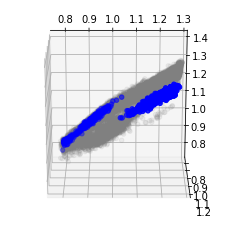

In [11]:
#uncomment for interactive 3d plot
#%matplotlib notebook

hyperparams_dict['res_size'] = 3
Sigs_3d = get_signature(paths,hparams = hyperparams_dict)

test_digit = 5
index_test = df['Digit']==test_digit

fig = plt.figure()
ax = plt.axes(projection='3d')

## all classes different color
#ax.scatter3D(Sigs_3d[:,0],Sigs_3d[:,1],Sigs_3d[:,2], c = df['Digit'])

## one v all
ax.scatter3D(Sigs_3d[index_test,0],Sigs_3d[index_test,1],Sigs_3d[index_test,2], c = 'blue')
ax.scatter3D(Sigs_3d[~index_test,0],Sigs_3d[~index_test,1],Sigs_3d[~index_test,2], c = 'grey',alpha = 0.1)
ax.view_init(110,270)
fig.savefig('digit_'+str(test_digit)+'.pdf')
## 5 seem to have multimodal distribution, or maybe some misslabeled instances(?)

### Plotting the ECDF of the Normal vs Anomalous observations

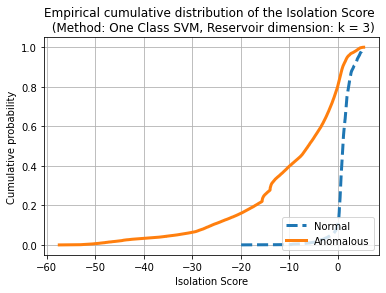

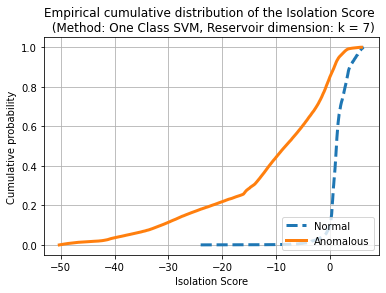

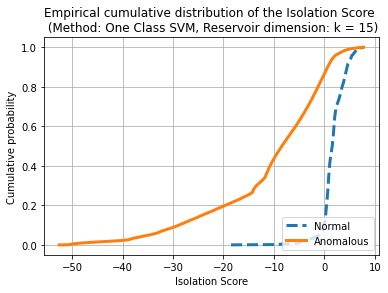

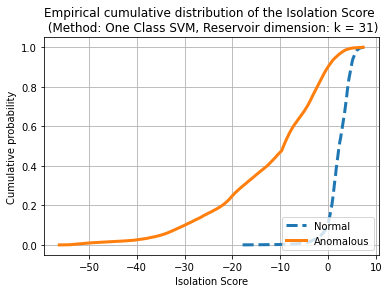

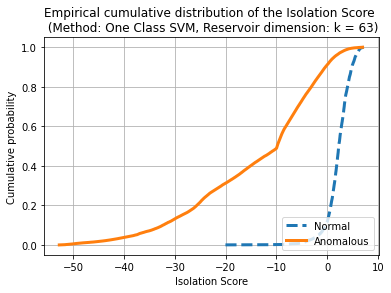

In [13]:
res_sizes = [3,7,15,31,63]
for N in res_sizes:
    hyperparams_dict['res_size'] = N
    util.plot_score(paths, df, clf, hyperparams_dict)
